# Phase 1: Exploratory Data Analysis (Dataset 1)

---
## Table of Contents
1. [Introduction](#1-introduction)
2. [Data Loading](#2-loading-libraries-and-dataset)
3. [Data Exploration](#3-data-exploration)
   - 3.1 [Links Dataset](#31-links-dataset)
   - 3.2 [Tags Dataset](#32-tags-dataset)
   - 3.3 [Movies Dataset](#33-movies-dataset)
   - 3.4 [Ratings Dataset](#34-ratings-dataset)

---

## 1. Introduction
In this notebook, we perform an exploratory data analysis (EDA) on **Dataset 1**.  
Goals of this notebook:
- Understand the structure of the dataset.  
- Check for missing values and inconsistencies.  
- Perform exploratory statistics and visualizations.  
- Extract insights that will guide preprocessing and modeling.  


## 2. Loading Libraries and Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from collections import Counter



In [2]:
# Loading the datasets
links_df = pd.read_csv('../data/raw/dataset1/links.csv')
movies_df = pd.read_csv('../data/raw/dataset1/movies.csv')
ratings_df = pd.read_csv('../data/raw/dataset1/ratings.csv')
tags_df = pd.read_csv('../data/raw/dataset1/tags.csv')

##### 3. Data Exploration

##### **3.1 LINKS DATASET**

In [3]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


- Dataset contains 9734 movie IDs from TMDb and 9,742 movie IDs from IMDb and MovieLens → functions as a mapping/reference table.  
- No cleaning required since it only links IDs across sources.  
- Primary use: joining/merging with the TMDB dataset for metadata enrichment.  


##### **3.2 TAGS DATASET**

In [5]:
# Getting the info of the dataset
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [6]:
# Converting the 'timestamp' column to datetime format
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')
# Displaying random rows from the tags dataset
tags_df.sample(5)

,userId,movieId,tag,timestamp
2599,477,4878,dreamlike,2009-05-16 17:21:02
3649,599,2959,narrated,2017-06-26 06:02:14
1367,474,1246,High School,2006-01-13 22:28:54
1916,474,4447,lawyers,2006-01-23 16:11:14
1050,474,237,France,2006-01-24 21:18:48


In [7]:
# Converting all tags to lowercase for consistency
tags_df['tag'] = tags_df['tag'].str.lower().str.strip()

# Join all tags for a movie into a list
tags_agg = tags_df.groupby('movieId')['tag'].apply(lambda x: list(set(x))).reset_index()
tags_agg.columns = ['movieId', 'tags_list']

In [8]:
tags_agg.info()

# Saving the aggregated tags to a CSV file
tags_agg.to_csv('../data/processed/dataset1/tags_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    1572 non-null   int64 
 1   tags_list  1572 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.7+ KB


- Original tags dataset: 3,683 rows → after grouping, reduced to 1,572 unique movies with tag lists.  
- `userId` dropped correctly since focus is on movie-level metadata, not individual tagging behavior.  
- `tags_list` now provides richer textual descriptors per movie → useful for content-based filtering.  
- Coverage: only 1,572 movies tagged → less than half of full dataset, may introduce sparsity in recommendations.  


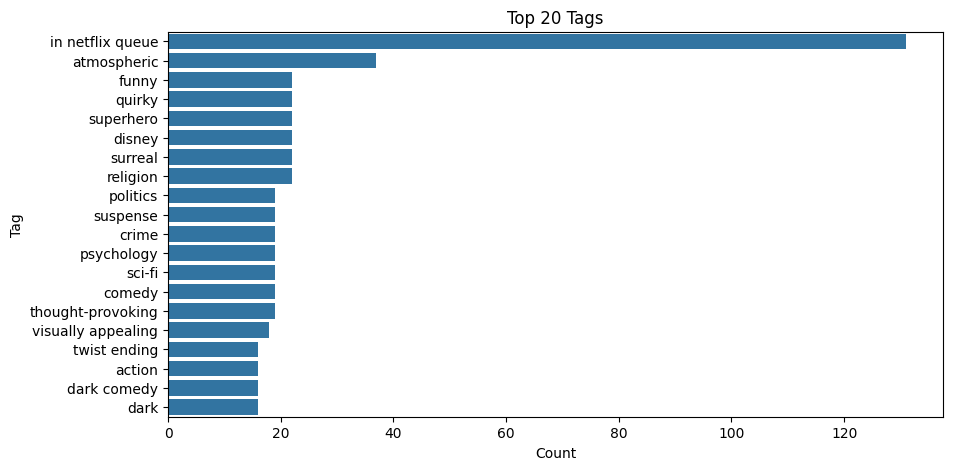

In [9]:
# Count top tags from tags_df
tag_counter = Counter(t for tag_list in tags_agg['tags_list'] for t in tag_list)
top_tags = pd.DataFrame(tag_counter.most_common(20), columns=['Tag', 'Count'])

# Plot top tags
plt.figure(figsize=(10, 5))
sns.barplot(data=top_tags, y='Tag', x='Count')
plt.title("Top 20 Tags")
plt.show()

- Top tag is **"in netflix queue" (131)** → platform-specific, may add noise vs. content-related tags.  
- Content-descriptive tags (e.g., *atmospheric, quirky, superhero, suspense, dark comedy*) appear with lower counts (~16–37).  
- Distribution is highly skewed → heavy reliance on few frequent tags.  
- Many tags reflect subjective impressions (*funny, thought-provoking, visually appealing*) → useful for diversity in recommendations.  
- Filtering out platform-specific or non-content tags will be put into consideration.

##### **3.3 MOVIES DATASET**


In [10]:
# getting the info of the dataset
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [11]:
# Getting random rows of the dataset
movies_df.sample(5)

,movieId,title,genres
8161,102590,Darkon (2006),Documentary|Fantasy
3247,4389,Lost and Delirious (2001),Drama
5536,26603,Prince of Darkness (1987),Fantasy|Horror|Sci-Fi|Thriller
7000,67665,Anvil! The Story of Anvil (2008),Documentary|Musical
1730,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War


This dataset needs to be cleaned so I'll;

- Extract `release_year` from `title` using regex.  
- Split `genres` column on `|` to create `genres_list` for multi-label analysis.  
- Removed movies with missing or invalid `title/genres` entries.  
- Preserved `movieId` as key identifier for linking with other datasets.  


In [12]:
# Extracting the year from the title and cleaning the title
movies_df['release_year'] = movies_df['title'].str.extract(r'\((\d{4})\)')
movies_df['title'] = movies_df['title'].str[:-6]

In [13]:
# Function to correct titles
def fix_title(title):
    match = re.match(r"^(.*),\s(The|An|A)$", title)
    if match:
        return f"{match.group(2)} {match.group(1)}"
    return title

# Apply to the column
movies_df['title'] = movies_df['title'].apply(fix_title)

In [14]:
# Function to fix titles
def fix_title(title):
    title = title.strip()
    # Separate parenthesis part
    paren_part = ''
    paren_match = re.search(r"\s*(\([^)]*\))\s*$", title)
    if paren_match:
        paren_part = paren_match.group(1)
        title = title[:paren_match.start()].strip()
    
    # Match titles like "Black, The" or "Good, the Bad and the Ugly, The"
    match = re.match(r"^(.*),\s(The|An|A)$", title)
    if match:
        new_title = f"{match.group(2)} {match.group(1)}"
        return f"{new_title} {paren_part}".strip()
    
    # No match — return original title
    return f"{title} {paren_part}".strip()

# 2. Apply to a few entries
movies_df['title'] = movies_df['title'].apply(fix_title)


In [15]:
# Claeaning the genre column and converting it to a list
movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
# Counting the occurences of each genre
genre_counter = Counter(g for genre_list in movies_df['genres_list'] for g in genre_list)
genre_counts = pd.DataFrame(genre_counter.most_common(), columns=['Genre', 'Count'])
unique_genre = set(genre_counts['Genre'].unique()) # gets a list of all unique genres
# save as a pickle file
with open('../src/artifacts/unique_genre.pkl', 'wb') as f:
    pickle.dump(unique_genre, f)
genre_counts

,Genre,Count
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


- Genre distribution is highly imbalanced → **Drama (4,361)** and **Comedy (3,756)** dominate.  
- Mid-range genres: *Thriller, Action, Romance* (1,500–1,800 range).  
- Niche/rare genres: *Film-Noir (87), IMAX (158), Western (167)* → may limit recommendation diversity.  
- 34 movies have `(no genres listed)` → candidates for exclusion or tagging via external metadata.  


In [16]:
# Remove rows with empty genre list
movies_df = movies_df[movies_df['genres_list'].apply(lambda x: len(x) > 0 and '(no genres listed)' not in x)]
movies_df.info()

# saving the cleaned dataset
movies_df.to_csv('../data/processed/dataset1/movies_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 9708 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieId       9708 non-null   int64 
 1   title         9708 non-null   object
 2   genres        9708 non-null   object
 3   release_year  9704 non-null   object
 4   genres_list   9708 non-null   object
dtypes: int64(1), object(4)
memory usage: 455.1+ KB


- Cleaned dataset reduced from 9,742 → 9,708 movies (34 dropped, due to genres).  
- Added `release_year` column → 4 missing values remain, may need imputation or exclusion.  
- `genres_list` created for easier multi-label processing (better for encoding/similarity).  
- Overall structure now richer and more analysis-ready, while maintaining most of the data coverage.  


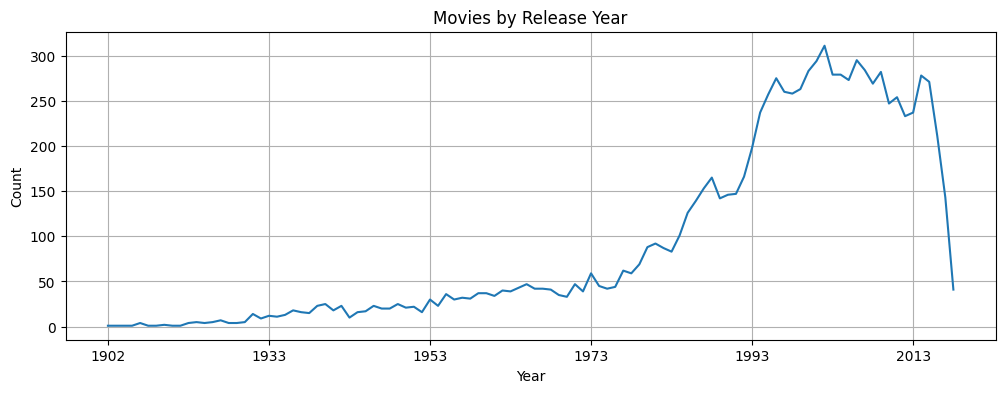

In [17]:
# Plot movie counts by year
year_counts = movies_df['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
year_counts.plot()
plt.title("Movies by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

- Dataset spans 1902–2018 → wide historical coverage.  
- Steady growth until ~1990, then sharp increase in yearly movie counts.  
- Post-1990: consistently ≥150 movies/year, peaking at 300+ in 2002.  
- Bulk of data concentrated in modern era (1990–2018) → recommendations likely biased toward recent films.  


##### **3.4 RATINGS DATASET**


In [18]:
# Getting the info of the dataset
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df.sample(5)

,userId,movieId,rating,timestamp
25404,177,6958,2.5,2015-07-02 11:49:11
69335,448,4339,4.0,2002-04-24 16:24:35
88622,572,1952,5.0,1999-12-22 19:07:56
25655,177,69122,4.0,2015-06-28 23:09:21
65510,420,3462,3.5,2008-08-06 16:58:16


In [20]:
# Saving the cleaned dataset
ratings_df.to_csv('../data/processed/dataset1/ratings_cleaned.csv', index=False)
# Ensuring there is no abnormal entry in the dataset
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836
mean,326.127564,19435.295718,3.501557,2008-03-19 17:01:27.368469248
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55
25%,177.000000,1199.000000,3.000000,2002-04-18 09:57:46
50%,325.000000,2991.000000,3.500000,2007-08-02 20:31:02
75%,477.000000,8122.000000,4.000000,2015-07-04 07:15:44.500000
max,610.000000,193609.000000,5.000000,2018-09-24 14:27:30
std,182.618491,35530.987199,1.042529,NaN


- 100,836 ratings from 610 unique users → good density for collaborative filtering.  
- Ratings range: 0.5 to 5.0 (step of 0.5) → standard MovieLens format.  
- Mean rating ≈ 3.5 → users tend toward positive ratings.  
- Distribution: 25% ≤ 3.0, 50% = 3.5, 75% ≥ 4.0 → skewed toward higher ratings.  


In [21]:
# Display basic stat about the dataset
print("Number of users:", ratings_df['userId'].nunique())
print("Number of movies:", ratings_df['movieId'].nunique())
print("Number of ratings:", len(ratings_df))

Number of users: 610
Number of movies: 9724
Number of ratings: 100836


- User base: 610 → relatively small compared to number of movies.  
- Movie catalog: 9,724 → large item space vs. users.  
- Ratings: 100,836 → average ≈ 165 ratings per user, ≈ 10 ratings per movie.  
- Data is **sparse** (low user-to-movie coverage) → collaborative filtering may suffer, content-based methods will be important.  


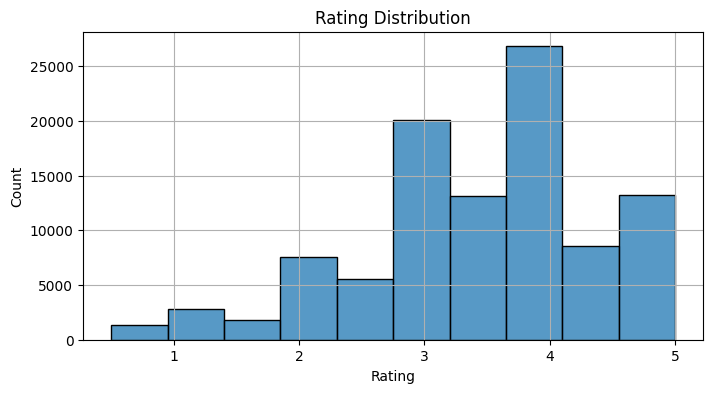

In [22]:
# Plotting the distribution of ratings
plt.figure(figsize=(8, 4))
sns.histplot(ratings_df['rating'], bins=10, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

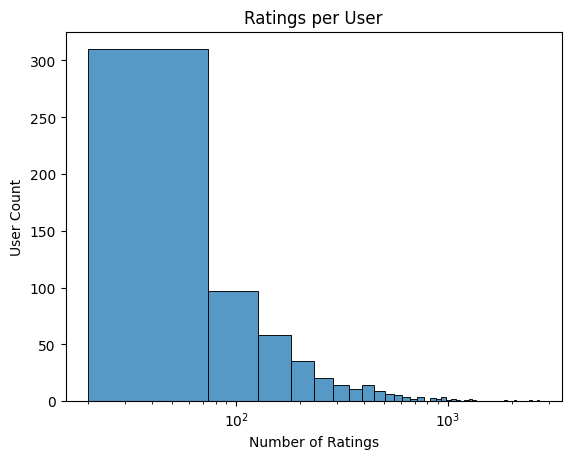

In [23]:
# Plotting the distribution of ratings per user
user_counts = ratings_df['userId'].value_counts()
sns.histplot(user_counts, bins=50)
plt.title("Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.xscale('log')
plt.show()


Each user has rated at least 20 movies


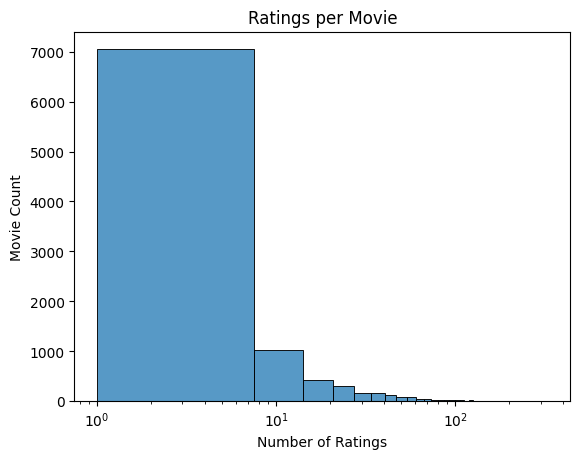

In [24]:
# Plotting the distribution of ratings per movie
movie_counts = ratings_df['movieId'].value_counts()
sns.histplot(movie_counts, bins=50)
plt.title("Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Count")
plt.xscale('log')
plt.show()



In [25]:
# Merge Ratings_df + Movies_df
df = ratings_df.merge(movies_df, on='movieId', how='left')

# Convert genres_list to tuple for duplicate check, handling NaN
if 'genres_list' in df.columns:
	df['genres_list'] = df['genres_list'].apply(lambda x: tuple(x) if isinstance(x, (list, tuple)) else ())

# Check for Duplicates
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   userId        100836 non-null  int64         
 1   movieId       100836 non-null  int64         
 2   rating        100836 non-null  float64       
 3   timestamp     100836 non-null  datetime64[ns]
 4   title         100789 non-null  object        
 5   genres        100789 non-null  object        
 6   release_year  100781 non-null  object        
 7   genres_list   100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 6.2+ MB


In [27]:
# Convert back to list
if 'genres_list' in df.columns:
	df['genres_list'] = df['genres_list'].apply(list)

In [28]:
# Sparsity
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = 1 - len(df) / (n_users * n_items)
print(f"Sparsity of ratings matrix: {sparsity:.4f}")


Sparsity of ratings matrix: 0.9830


- Ratings matrix sparsity = **98.3%** → very few user–movie pairs are rated.  
- Confirms strong data sparsity challenge → typical of recommender datasets.  
- Reinforces need for **content-based filtering** and hybrid methods to complement collaborative filtering.  


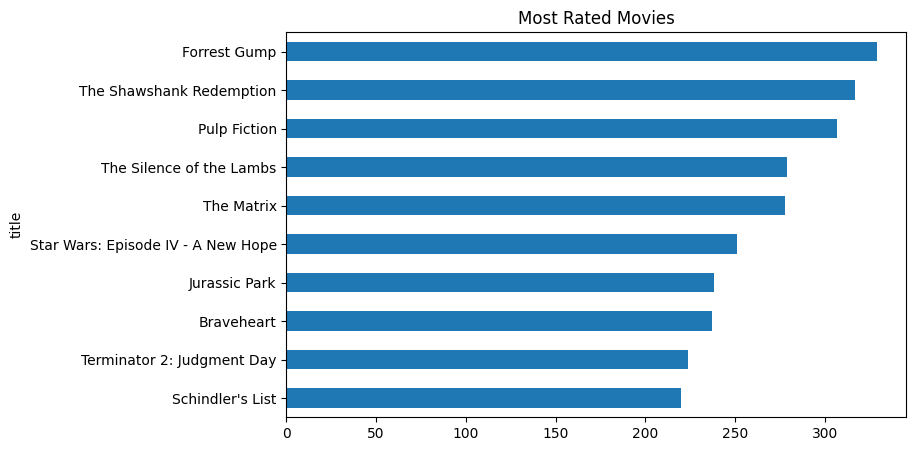

In [29]:
# Popular Movies
pop_movies = df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
pop_movies.plot(kind='barh', title='Most Rated Movies', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.show()

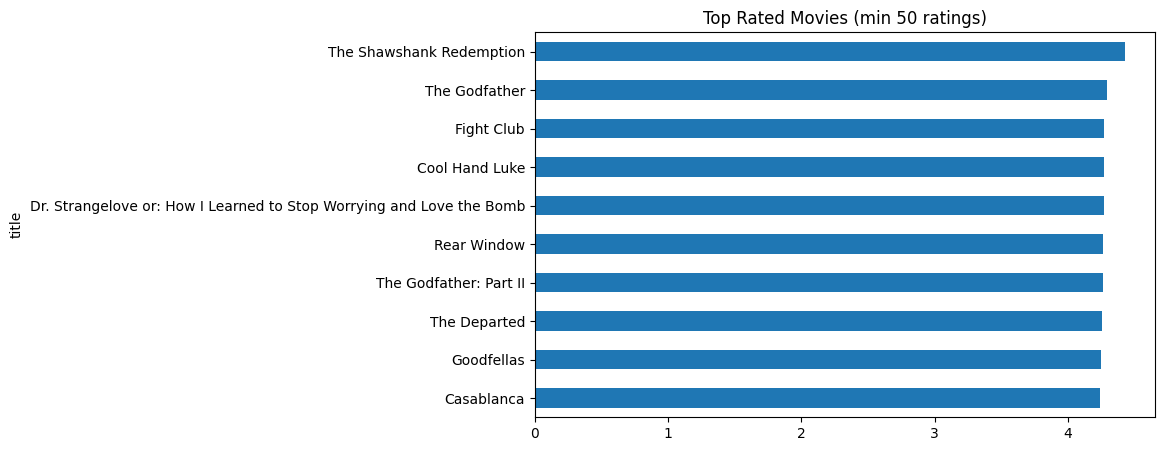

In [30]:
# High Rated Movies (with filter)
high_rated = df.groupby('title')['rating'].agg(['mean', 'count'])
filtered = high_rated[high_rated['count'] > 50].sort_values('mean', ascending=False).head(10)
filtered['mean'].plot(kind='barh', title='Top Rated Movies (min 50 ratings)', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.show()

- Most rated movies are well-known mainstream titles (*Forrest Gump, Shawshank Redemption, Pulp Fiction, The Matrix*), reflecting popularity bias.  
- Top-rated (≥50 ratings) are classics (*Shawshank Redemption, The Godfather, Fight Club, Casablanca*), showing strong critical acclaim overlap.  
- Difference between "most rated" vs "top rated" lists highlights:  
  - **Popularity bias** → mainstream blockbusters dominate rating counts.  
  - **Quality bias** → critically acclaimed classics achieve highest average ratings.  
- Both patterns suggest the recommender must balance popularity with rating quality to avoid over-recommending only blockbusters.  


In [31]:
# Merge into the movie metadata
movies = df.merge(tags_agg, on='movieId', how='left')

# Replace NaNs with empty lists
movies['tags_list'] = movies['tags_list'].apply(lambda x: x if isinstance(x, list) else [])

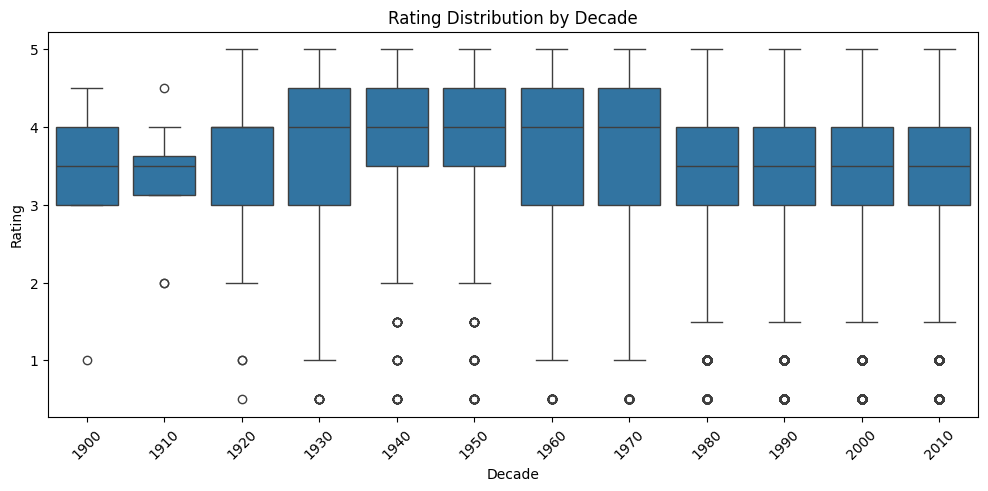

In [32]:
# Create decade column (convert release_year to numeric first)
movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')
movies['decade'] = (movies['release_year'] // 10 * 10).astype('Int64')

# Join with ratings to see rating behavior over time
plt.figure(figsize=(12, 5))
sns.boxplot(data=movies, x='decade', y='rating')
plt.title("Rating Distribution by Decade")
plt.xlabel("Decade")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()

- Ratings across **1980–2010** show nearly identical distribution → stable user rating behavior in modern decades.  
- **Median rating = 3.5** for all, except **1930–1970 (median = 4)** → suggests older/classic films received higher appreciation.  
- Outliers pattern consistent across decades → no major shifts in extreme ratings.  
- Only well-known older movies in dataset.  


In [33]:
# Dropping genre column
movies = movies.drop(columns=['genres', 'timestamp'])
# Save the final cleaned dataset
movies.to_csv('../data/processed/dataset1/full_movies_cleaned.csv', index=False)